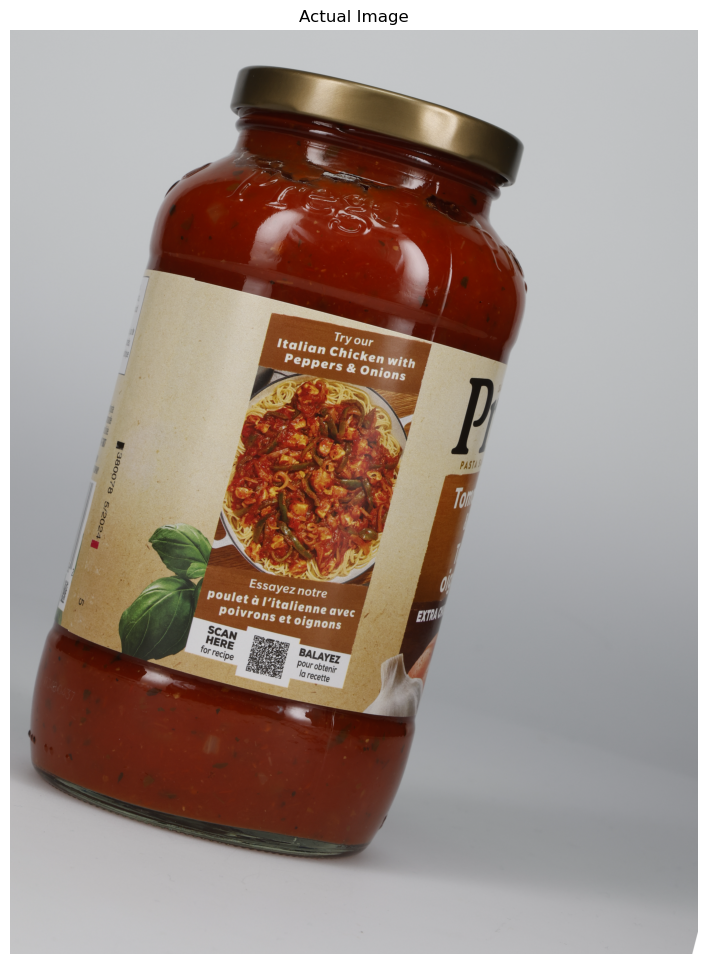

In [1]:
# 📦 STEP 1: Imports
import cv2
import numpy as np
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True
%matplotlib inline

# 📥 STEP 2: Load Image in Color
image_path = "Edited Image.tif"  # <-- update this to your file location
image_pil = Image.open(image_path).convert("RGB")
img = np.array(image_pil)

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')
plt.title("Actual Image")
plt.show()


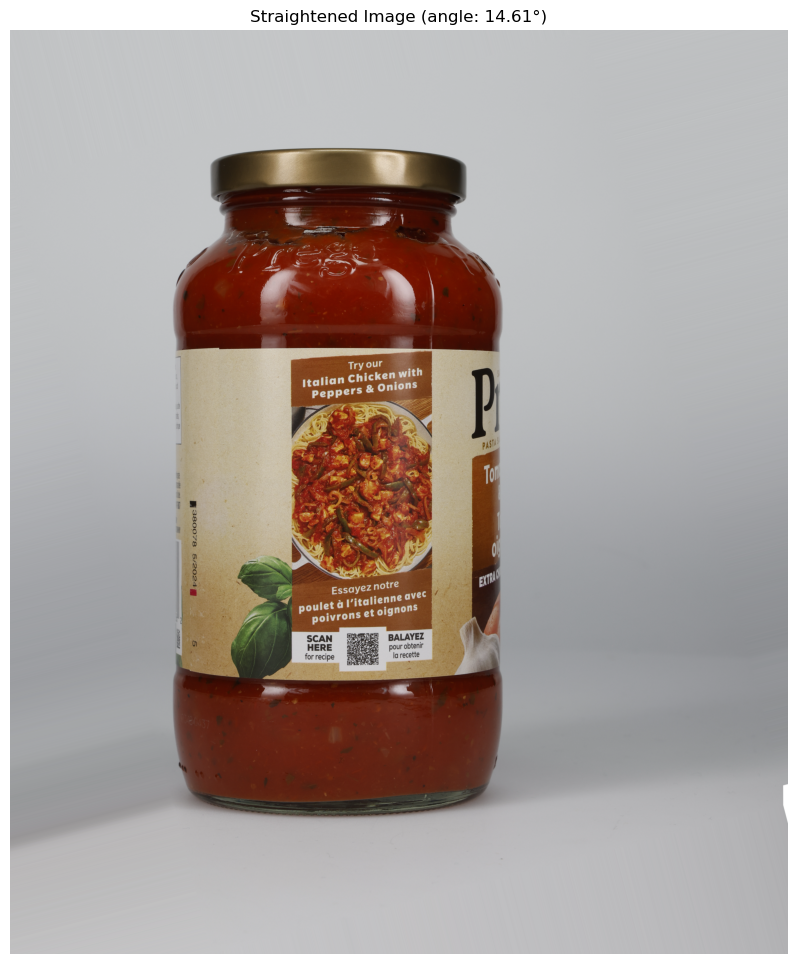

In [2]:
# 🧹 STEP 3: Preprocess (Edge Detection for Label)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)

# Find contours and select largest one
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]  # Get top 5 largest

# Find the best contour (simple area-based selection - modify if needed)
largest_contour = None
max_area = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
        max_area = area
        largest_contour = cnt

# Get rotation angle from minimum area rectangle
rect = cv2.minAreaRect(largest_contour)
angle = rect[-1]
# Fix angle quirks from OpenCV
if angle < -45:
    angle += 90
elif angle > 45:
    angle -= 9


# 🎯 STEP 4: Smart Rotation with Auto-Scaling
(h, w) = img.shape[:2]
# angle = 18  # Your detected angle from STEP 3
center = (w // 2, h // 2)

# Calculate expanded dimensions
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
abs_cos = abs(rotation_matrix[0,0])
abs_sin = abs(rotation_matrix[0,1])

# New dimensions to prevent cropping
bound_w = int(h * abs_sin + w * abs_cos)
bound_h = int(h * abs_cos + w * abs_sin)

# Adjust rotation matrix to center the content
rotation_matrix[0, 2] += bound_w/2 - w/2
rotation_matrix[1, 2] += bound_h/2 - h/2

# Perform rotation with expanded canvas
rotated = cv2.warpAffine(img, rotation_matrix, (bound_w, bound_h),
flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


# 📊 STEP 5: Visualization
plt.figure(figsize=(12, 12))
plt.imshow(rotated)
plt.axis('off')
plt.title(f"Straightened Image (angle: {angle:.2f}°)")
plt.show()